In [1]:
import asyncio
import numpy as np
from scipy.spatial.transform import Rotation as R

import time

from intrepid_environment.simulator import Simulator

In [2]:
import matplotlib.pyplot as plt

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
sim = Simulator()
await sim.connect()

17765625

In [5]:
async def restart_drone():
    await sim.rpc("session.restart")
    entity = await sim.rpc("map.spawn_uav", {
        "robot_id": 0,
        "position": {
            "x": 0,
            "y": 0,
            "z": 0,
        },
    })
    time.sleep(1.0)
    await sim.rpc("session.run", {"speed": 2.0})
    return entity

In [6]:
entity = await restart_drone()

Setup trajectory for drone to follow.

In [7]:
from quadcopter_control.trajectory import Trajectory, TrajectoryPoint

In [ ]:
async def sim_step(motors):
    (sim_time, _, drone_state) = await asyncio.gather(
        sim.step(),
        sim.rpc(f"object_{entity}.actuator_control", motors),
        sim.rpc("script.eval", {
                "code": """{
                    position = sim.object.position(ARGS),
                    attitude = sim.object.rotation_quat(ARGS),
                    attitude_euler = sim.object.rotation_angles(ARGS),
                    velocity = sim.object.linear_velocity(ARGS),
                    omega = sim.object.angular_velocity(ARGS),
                    acceleration = sim.object.acceleration(ARGS),
                }""",
                "args": entity,
                }),
    )

    acceleration = np.array([drone_state['acceleration']['x'],
                             drone_state['acceleration']['y'],
                             drone_state['acceleration']['z']], dtype=np.float64)

    position = np.array([drone_state['position']['x'],
                        drone_state['position']['y'],
                        drone_state['position']['z']], dtype=np.float64)

    velocity = np.array([drone_state['velocity']['x'],
                        drone_state['velocity']['y'],
                        drone_state['velocity']['z']], dtype=np.float64)

    attitude = R.from_quat([
        drone_state['attitude'][0],
        drone_state['attitude'][1],
        drone_state['attitude'][2],
        drone_state['attitude'][3],
    ])

    # attitude_euler = np.array([
    #     drone_state['attitude_euler']['zx'],
    #     -drone_state['attitude_euler']['yz'],
    #     drone_state['attitude_euler']['xy'],
    # ])

    attitude_euler = np.array([
        -drone_state['attitude_euler']['yz'],
        drone_state['attitude_euler']['zx'],
        drone_state['attitude_euler']['xy'],
    ])

    # print("euler", attitude_euler)
    # print("quat", attitude.as_euler('xyz', degrees=False))
    # print("----")
    # print(attitude.as_quat())
    # print(R.from_euler("xyz",attitude_euler).as_quat())

    attitude = R.from_euler("yxz", attitude_euler)

    omega = np.array([drone_state['omega']['zx'],
                      -drone_state['omega']['yz'],
                     drone_state['omega']['xy']], dtype=np.float64)

    return {
        'time': sim_time,
        'acceleration': acceleration,
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'attitude_euler': attitude_euler,
        'omega': omega
    }

In [9]:
async def get_trajectory_with_initial_position():
    state = await sim_step([0, 0, 0, 0])

    starting_point = TrajectoryPoint(
        time=state['time'],
        acceleration=state['acceleration'],
        attitude=state['attitude'],
        omega=state['omega'],
        position=state['position'],
        velocity=state['velocity'],
    )

    trajectory = Trajectory()
    trajectory.add_point(starting_point)

    return trajectory

In [10]:
trajectory_time_offset = 0
dp = np.zeros(3)

def get_next_trajectory_point(trajectory, sim_time, dt, dp):
    pt = trajectory.next_trajectory_point((sim_time + dt) / 1000.0)
    pt.position += dp
    return pt

In [11]:
from quadcopter_control.controller import QuadcopterController, calculate_drone_moment_of_inertia

In [12]:
DRONE_HEIGHT = 0.028
DRONE_RADIUS = 0.05
DRONE_MASS = 0.041

In [13]:
(Ixx, Iyy, Izz) = calculate_drone_moment_of_inertia(DRONE_HEIGHT, DRONE_RADIUS, DRONE_MASS)
(Ixx, Iyy, Izz)

(2.830366666666667e-05, 2.830366666666667e-05, 5.125000000000001e-05)

## Scenario -1: Determine Drone Motor / to Newton Rate

In [14]:
# drone_force = 9.81 * DRONE_MASS; drone_force

In [15]:
# positions = []
# forces = []

In [16]:
# for force in np.arange(50, 51, 0.01):
#     print("trying force", force)
#     for _ in range(50):
#         state = await sim_step([force, force, force, force])
#         forces.append(force)
#         positions.append(state['position'][2])

In [17]:
# plt.plot(positions[:1250])
# plt.plot(forces[:1250])
# plt.title("z", fontsize=20)
# plt.show()

In [18]:
scale = 0.40221 / (50.2*4); scale

0.0020030378486055778

500 = 1 newton

## Scenario 0: Zero Gains

Test whether controller runs without controller gains set.

In [19]:
trajectory = await get_trajectory_with_initial_position()

In [20]:
DT_MS = 15.625  # 64 hz

In [21]:
quadcopter_controller = QuadcopterController(
    DT_MS / 1e3,
    DRONE_MASS,
    Ixx, Iyy, Izz,
    l=0.05,
    max_tilt_angle=0.7,
    max_ascent_rate=5.0,
    max_vel_xy=5,
    max_accel_xy=12,
)

## Scenario 1: Altitude Control

Tune gains until drone stays in place. on a desired height.

In [22]:
state = await sim_step([0, 0, 0, 0])
trajectory = await get_trajectory_with_initial_position()

In [23]:
sim_time = (await sim_step([0, 0, 0, 0]))['time']
n_episodes = 200

for i in range(0, n_episodes):
    trajectory.add_point(TrajectoryPoint(
        time=(sim_time + (i*DT_MS*1e3) / 1e6),
        position=np.array([0.0, 0.0, 5.0]),
        velocity=np.zeros(3),
        acceleration=np.zeros(3),
        attitude=R.from_quat([0.0, 0.0, 0.0, 1.0]),
        omega=np.array([0.1, 0.1, 0.1])
    ))

In [24]:
import time
import matplotlib.pyplot as plt

In [25]:
from tqdm import tqdm

In [26]:
async def tune_controller(
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=n_episodes,
):

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    accelerations = []
    attitudes = []
    bx_cmds = []
    by_cmds = []

    bx_errs = []
    by_errs = []

    des_accs = []
    des_omegas = []
    est_omegas = []

    state = await sim_step([0, 0, 0, 0])

    for _ in tqdm(range(n_episodes)):
        t = (state['time'] + DT_MS * 1e3) / 1e6
        traj_pt = trajectory.next_trajectory_point(t)

        motors, (bx_cmd, by_cmd, bx_err, by_err, des_acc, des_omega) = quadcopter_controller.run_control(
            traj_pt,
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )

        motors /= 0.02

        accelerations.append(state['acceleration'])
        attitudes.append(state['attitude_euler'])
        bx_cmds.append(bx_cmd)
        by_cmds.append(by_cmd)
        bx_errs.append(bx_err)
        by_errs.append(by_err)
        des_accs.append(des_acc)
        des_omegas.append(des_omega)
        est_omegas.append(state['omega'])

        motors = np.clip(motors, 40, 500)
        positions.append(state['position'])
        times.append(t)
        state = await sim_step(motors.tolist())

    return (
        np.array(times), 
        np.array(positions), 
        np.array(accelerations),
        np.array(attitudes),
        np.array(bx_cmds), 
        np.array(by_cmds), 
        np.array(bx_errs), 
        np.array(by_errs), 
        np.array(des_accs), 
        np.array(des_omegas),
        np.array(est_omegas),
    )

In [27]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=5.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Oscilates, fine, but rate of oscilations increases

In [28]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=5.0,
#     kp_pos_z=6.0,
#     kp_vel_z=6.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Better

In [29]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=3.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Better

In [30]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=2.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

Better

In [31]:
# entity = await restart_drone()

# (times, positions) = await tune_controller(
#     kp_pqr=np.array([0.0, 0.0, 0.0]),
#     ki_pos_z=1.0,
#     kp_pos_z=5.0,
#     kp_vel_z=5.0,
#     kp_pos_xy=0.0,
#     kp_vel_xy=0.0,
#     kp_yaw=0.0,
#     kp_bank=0.0,
#     n_episodes=1500,
# )

# plt.title("altitude")
# plt.plot(times, positions[:,2])
# plt.show()

## Scenario 2: Position Control


In [32]:
entity = await restart_drone()
state = await sim_step([0, 0, 0, 0])
trajectory = await get_trajectory_with_initial_position()

In [33]:
sim_time = (await sim_step([0, 0, 0, 0]))['time']
n_episodes = 200

for i in range(0, n_episodes):
    trajectory.add_point(TrajectoryPoint(
        time=(sim_time + (i*DT_MS*1e3) / 1e6),
        position=np.array([0.0, 0.0, 10.0]),
        velocity=np.zeros(3),
        acceleration=np.zeros(3),
        attitude=R.from_quat([0.0, 0.0, 0.0, 1.0]),
        omega=np.array([0.0, 0.0, 0.0])
    ))

In [35]:
entity = await restart_drone()

(times,
 positions,
 accelerations,
 attitudes,
 bx_cmds, by_cmds,
 bx_errs, by_errs,
 des_accs, des_omegas, est_omegas) = await tune_controller(
    kp_pqr=np.array([-1.5, -1.5, 0.1]),
    ki_pos_z=3.0,
    kp_pos_z=6.0,
    kp_vel_z=6.0,
    kp_pos_xy=5.0,
    kp_vel_xy=0.0,
    kp_yaw=0.0,
    kp_bank=0.8,
    n_episodes=1000,
)

100%|██████████| 1000/1000 [00:44<00:00, 22.51it/s]


In [ ]:
rx_s = []
ry_s = []

for i in range(attitudes.shape[0]):
    r = R.from_euler("yxz",attitudes[i]).as_matrix()
    rx_s.append(r[0, 2])
    ry_s.append(-r[1, 2])

In [ ]:
# # plt.title("altitude")
# # plt.plot(times, positions[:,2])
# # plt.show()

# plt.title("x")
# plt.plot(times, positions[:,0])
# plt.show()

# plt.title("des_accs[x]")
# plt.plot(times, des_accs[:,0])
# plt.show()


# plt.title("rx_s")
# plt.plot(times, rx_s)
# plt.show()

# plt.title("bx_cmd")
# plt.plot(times, bx_cmds)
# plt.show()

# # plt.title("y")
# # plt.plot(times, positions[:,1])
# # plt.show()


# # plt.title("ry_s")
# # plt.plot(times, ry_s)
# # plt.show()

# # plt.title("by_cmd")
# # plt.plot(times, by_cmds)
# # plt.show()






# # plt.title("attitudes[x]")
# # plt.plot(times, attitudes[:, 0])
# # plt.show()

# # plt.title("des_accs[x]")
# # plt.plot(times, des_accs[:,0])
# # plt.show()




# # plt.title("des_accs[x]")
# # plt.plot(times, des_accs[:, 0])
# # plt.show()

# # plt.title("est_accs[x]")
# # plt.plot(times, accelerations[:, 0])
# # plt.show()

# # plt.title("des_omegas[x]")
# # plt.plot(times, des_omegas[:, 0])
# # plt.show()




# # plt.title("bx_errs")
# # plt.plot(times, bx_errs)
# # plt.show()


# # plt.title("y")
# # plt.plot(times, positions[:,1])
# # plt.show()

# # plt.title("des_accs[y]")
# # plt.plot(times, des_accs[:,1])
# # plt.show()

# # plt.title("by_cmds")
# # plt.plot(times, by_cmds)
# # plt.show()

# # plt.title("by_errs")
# # plt.plot(times, by_errs)
# # plt.show()



# # plt.title("des_omega[1]")
# # plt.plot(times, des_omegas[:, 1])
# # plt.show()

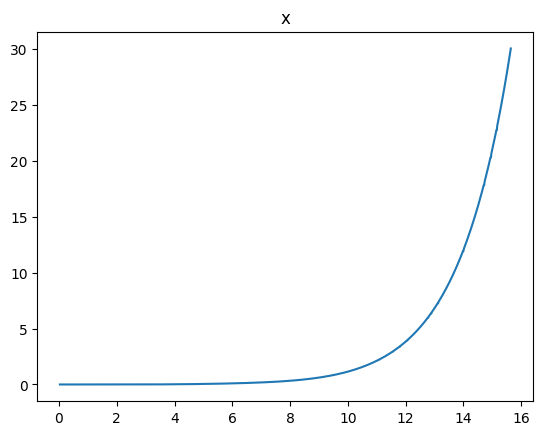

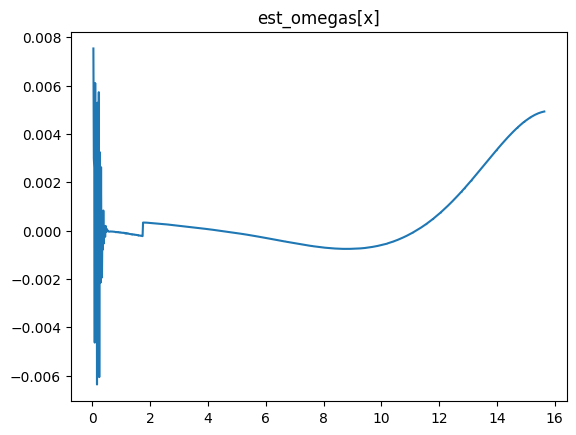

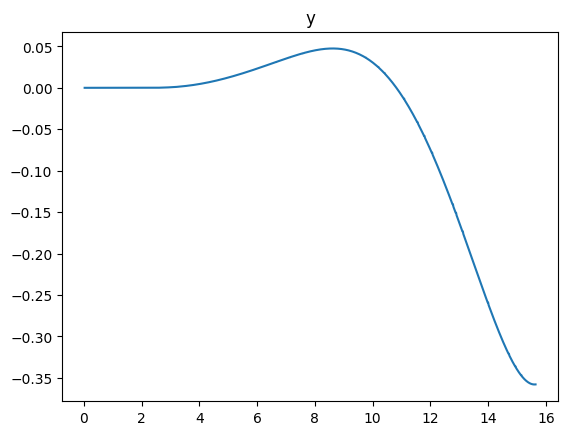

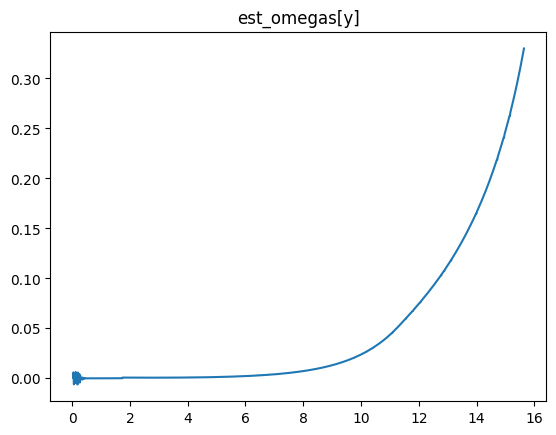

In [42]:
plt.title("x")
plt.plot(times, positions[:,0])
plt.show()

plt.title("est_omegas[x]")
plt.plot(times, est_omegas[:, 0])
plt.show()

plt.title("y")
plt.plot(times, positions[:,1])
plt.show()

plt.title("est_omegas[y]")
plt.plot(times, est_omegas[:, 1])
plt.show()


# plt.title("des_accs[x]")
# plt.plot(times, des_accs[:,0])
# plt.show()


# plt.title("rx_s")
# plt.plot(times, rx_s)
# plt.plot(times, attitudes[:, 0])
# plt.show()


# plt.title("bx_errs")
# plt.plot(times, bx_errs)
# plt.show()

# # plt.title("bx_errs")
# # plt.plot(times, bx_errs)
# # plt.show()

# plt.title("bx_cmds")
# plt.plot(times, bx_cmds)
# plt.show()

# plt.title("des_omegas[x]")
# plt.plot(times, des_omegas[:, 0])
# plt.show()





# plt.title("ry_s")
# plt.plot(times, ry_s)
# plt.plot(times, attitudes[:, 1])
# plt.show()


# plt.title("by_errs")
# plt.plot(times, by_errs)
# plt.show()



# plt.title("ryz_s")
# plt.plot(times, attitudes[:, 1])
# plt.show()

# plt.title("by_err")
# plt.plot(times, by_errs)
# plt.show()

# plt.title("bx_err")
# plt.plot(times, bx_errs)
# plt.show()

# plt.title("attitudes[x]")

# plt.show()

Reference implementation: https://github.com/martin0004/drone_control_system